# Introduction

Primary data sources on population are a rare resource in developing countries. When existant, civil registration systems are often patchy. Censuses are rare, and at best happening every 10 years. Meanwhile, in countries with democratic constitutions, elections are held on a more frequent basis. In West Africa, most Constitutions require elections for higher offices to be held every five years. Each time elections are held, voting lists have to be updated, to enlist new voters, and distribute voting identifications. Voters lists should record every person allowed to vote in a country, which can in most situation be equated to the adult population. In this regard, voters list could constitute an interesting data source, providing a regular update on the adult population of a country.

In 2015 and 2016, [27 african countries have planned presidential elections](http://libeafrica4.blogs.liberation.fr/2016/04/20/peut-en-cartographier-2016-la-grande-annee-electorale-en-afrique/), and more have planned local or legislative elections (list [for 2015](http://www.jeuneafrique.com/43179/politique/carte-interactive-o-et-quand-se-tiennent-les-lections-de-2015-en-afrique/) and [for 2016](http://www.jeuneafrique.com/mag/284560/politique/carte-elections-a-venir-afrique-cest-lalternance/). Some researchers and journalists have questioned the [credibility and regularity of some of these elections](http://www.lam.sciencespobordeaux.fr/page/afrique-presidentielles), as they question the way electoral lists are designed, suspecting partisan biases in the way voters are identified and registered. Meanwhile the systematic registration and identification of a sizeable chunk of populations, even if imperfect, should be considered as a huge opportunity to get or update data on these populations.

The update of electoral lists is indeed often a conflictual and highly politicized process. In African countries where vote is often overdetermined by geographic and ethnic origins of voters, suspicions of fraud are frequent, with under recording of some categories of voters, and over recording of other categories. Meanwhile, with the development of [better techniques for voters identification](https://regardexcentrique.wordpress.com/2015/06/10/la-biometrie-electorale-en-afrique-dossier/#_ftn1), and with the development of supervision by civil societies and international agencies, one can hope the completeness and quality of voters lists should be acceptable. Moreover, in order to improve transparence of electoral processes, voters lists are often made available for the public to control and correct.

## The Niger 2016 elections

In Niger, presidential and parlementary elections were held in February 2016. Voters lists were updated during the second half of the year 2015, under the supervision and control of a mission of the Office International de la Francophonie (OIF). The operations for registration of voters [were conducted during the third quarter of 2015](http://www.ceni-niger.org/article-region/#more-24). A first version of the voters list was [published on December 21, 2015](http://www.ceni-niger.org/article-region/#more-24), tallying 7,569,172 voters, out of 8,569,309 that were expected [based on the 2012 census](http://www.iinanews.org/page/public/news_details.aspx?id=98929&NL=True#)

Final lists were validated in early January 2016 after [being corrected](http://www.nigerdiaspora.net/les-infos-du-pays/politique-niger/politique-niger/item/72543-synthese-du-rapport-de-l-audit-du-fichier-electoral-le-guri-systeme-a-visage-decouvert-adieu-le-coup-k-o) for [some incoherencies](http://www.nigerinter.com/2016/01/le-fichier-electoral-du-niger-valable-sous-reserves/) noted by the supervisory body. [A final report on these lists](http://www.nigerinter.com/2016/05/remise-officielle-du-rapport-du-fichier-electoral-au-ministre-detat-a-linterieur-par-le-cfeb/) was published in may 2016. 

The Comission Electorale Nationale Independante (CENI) later made these lists fully available on its website.

This work purposes to evaluate how the information made available in voters lists compares with other data sources on Nigerien's population, and how it brings additional knowledge on this population.

# Data

Two main data sources are used in this work :
1. The list of electors, extracted from the CENI website
2. A geolocalized repertoire of all localities and there population, produced during Niger's latest Census

## Voters List

The voters' list was extracted from the [CENI's website](http://www.ceni-niger.org/) using Python's web extraction package _BeautifulSoup_. The extraction first navigated the CENI's website to get the hierarchy of Regions, Departments, Communes and Voting Stations. In a second step, each voting station voting list was read and saved in tabular format in separate files. The lists were then anonymized and compiled in a central file. 

For each voter, the covariates collected were : voting stations, commune, department and region, date of birth, profession. 

Data was obtained for 7,617,613 voters.


## Census / Répertoire National des Localités

The _Répertoire National des Localités_ (RENALOC) was downloaded as a pdf file from the [Institut National de la Statistique (INS) website](http://www.stat-niger.org/). The tables were extracted in bulk from this file using the Tabula Package, and then processed in Python to recompose the geographic structure of the document.

The final data consists in 34507 localities, for which the INS provides the number of inhabitants, by gender, as well as the number of households, and the number of agricultural households. For most of the localities, a GPS coordinate is recorded, as well as the type of locality (neighborhood, village, camp, water well, hamlet).

## Additional Data sources

Administrative boundaries for regions and departements were retrieved from the CENI's website. Boundaries for communes were retrieved from colleagues.

## Data Matching

All data sources (voters list, RENALOC, administrative boundaries) have been matched at commune level. For mapping purposes, some urban areas had to be collapsed at city level.

# Analysis
## Age Structure Imputation

In [1]:
## Usual Suspects
import pandas as pd
import matplotlib.pyplot as plt
import os as os
import numpy as np


## sklearn tools we will use
from sklearn import datasets , preprocessing
from sklearn.cross_validation import cross_val_predict
from sklearn import linear_model
from sklearn.feature_extraction import DictVectorizer

## Additional analytic tools
from scipy.interpolate import UnivariateSpline
import statsmodels.formula.api as smf

## For parralell computing
from joblib import Parallel, delayed

## IPython Display settings
import warnings
from IPython.core.display import HTML, display
warnings.filterwarnings('ignore')
%matplotlib inline
display(HTML("<style>.container { width:100% !important; }</style>"))

plotting = True

## Voters data
voters_data = pd.read_csv('../data/processed/voters_list.csv' , encoding = "ISO-8859-1")
voters_data = voters_data[(voters_data.age >= 18) & (voters_data.NOM_REGION != 'DIASPORA')]

## Featured data
model_data = pd.read_csv('../data/processed/commune_collapsed_matched.csv' , encoding = "ISO-8859-1")
model_data['urbain'] = list((model_data['commune'].str[0:14] == 'ARRONDISSEMENT') | (model_data['commune'] == model_data['region']))

### Getting age percentages

In [2]:
def age_distrib(data) :
    data.age[data.age > 100] = 100    
    out =  np.round(data.age).value_counts() / len(data)
    out = out.reset_index()
    out.columns = ['age' , 'percentage']
    return out

def get_age_distribution(data , level):
    out = data.groupby(level).apply(age_distrib).reset_index()
    sort_order = level + ['age']
    out = out.sort(sort_order, ascending=[1]*len(sort_order))
    i = len(level)
    lev_to_drop = 'level_' + str(i)
    del out[lev_to_drop]
    return out

def spl_age(data):
    out = UnivariateSpline(data['age'] , data['percentage'])
    return out

def impute_non_adulte(splines , age_adulte = 18):
    age_extrap = range(0,age_adulte)
    age_range = range(age_adulte,101)
    out = {'splined':list(splines(age_range)) , 
          'extrapol':list(splines(age_extrap))}
    return out

def get_spline_from_sample(voters_data , level):
    age_dist = get_age_distribution(voters_data , level)
    extrapolated_data = {}
    splines = age_dist.groupby(level).apply(spl_age)
    for region in list(splines.index.levels[0]) :
        sp_reg = splines[region]
        for departement in list(sp_reg.index.levels[0]) :
            sp_reg_d = sp_reg[departement]
            for commune in list(sp_reg_d.index) :
                splinned = impute_non_adulte(splines[region][departement][commune])
                extrapolated_data[region + '_' + commune] = {'commune' : commune ,
                                                         'departement' : departement ,
                                                         'region' : region ,
                                                         'splinned': splinned['splined'] ,
                                                         'extrapolated' : splinned['extrapol']}
    return extrapolated_data

In [69]:
level = ['NOM_REGION' , 'NOM_DEPART' , 'NOM_COMMUNE'] 

In [70]:
extrapolated_data = get_spline_from_sample(voters_data , level )
age_dist = get_age_distribution(voters_data , level )

In [ ]:
def sample_spline(voters_data , level):
    sample = np.random.choice(len(voters_data), 8*len(voters_data)/10 , replace = True)
    sample = voters_data.iloc[sample]
    u = get_spline_from_sample(sample , level)
    return u

def bootstrap_spline(voters_data = voters_data, level = level , n_rep = 100):
    out = Parallel(n_jobs=4, verbose=10 , backend = 'threading')(delayed(sample_spline)(voters_data , level) for i in range(n_rep))
    return out

boot_splines = voters_data.groupby(level).apply(bootstrap_spline)

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   14.4s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   18.2s finished
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    6.5s
[Parallel(n_job

In [72]:
len(boot_splines)

2

In [41]:
def get_spline_95IC(out_spline):
    ext5 = pd.DataFrame(list(splined_data['extrapolated'])).quantile(q=0.05, axis=0, numeric_only=True, interpolation='linear')
    ext95 = pd.DataFrame(list(splined_data['extrapolated'])).quantile(q=0.95, axis=0, numeric_only=True, interpolation='linear')
    
    spl5 = pd.DataFrame(list(splined_data['splinned'])).quantile(q=0.05, axis=0, numeric_only=True, interpolation='linear')
    spl95 = pd.DataFrame(list(splined_data['splinned'])).quantile(q=0.95, axis=0, numeric_only=True, interpolation='linear')
    return ([ext5 , ext95] , [spl5 , spl95])

In [43]:
splined_data = pd.DataFrame(boot_splines[0]).T
for i in range(1,len(boot_splines)):
    splined_data  = splined_data.append(pd.DataFrame(boot_splines[i]).T)

In [48]:
ICSplined = splined_data.groupby(['region' , 'departement' , 'commune']).apply(get_spline_95IC)

In [50]:
ICSplined = ICSplined.reset_index()

In [55]:
ICSplined.columns = ['region','departement','commune','IC95']

### Extrapolating non adult age groups

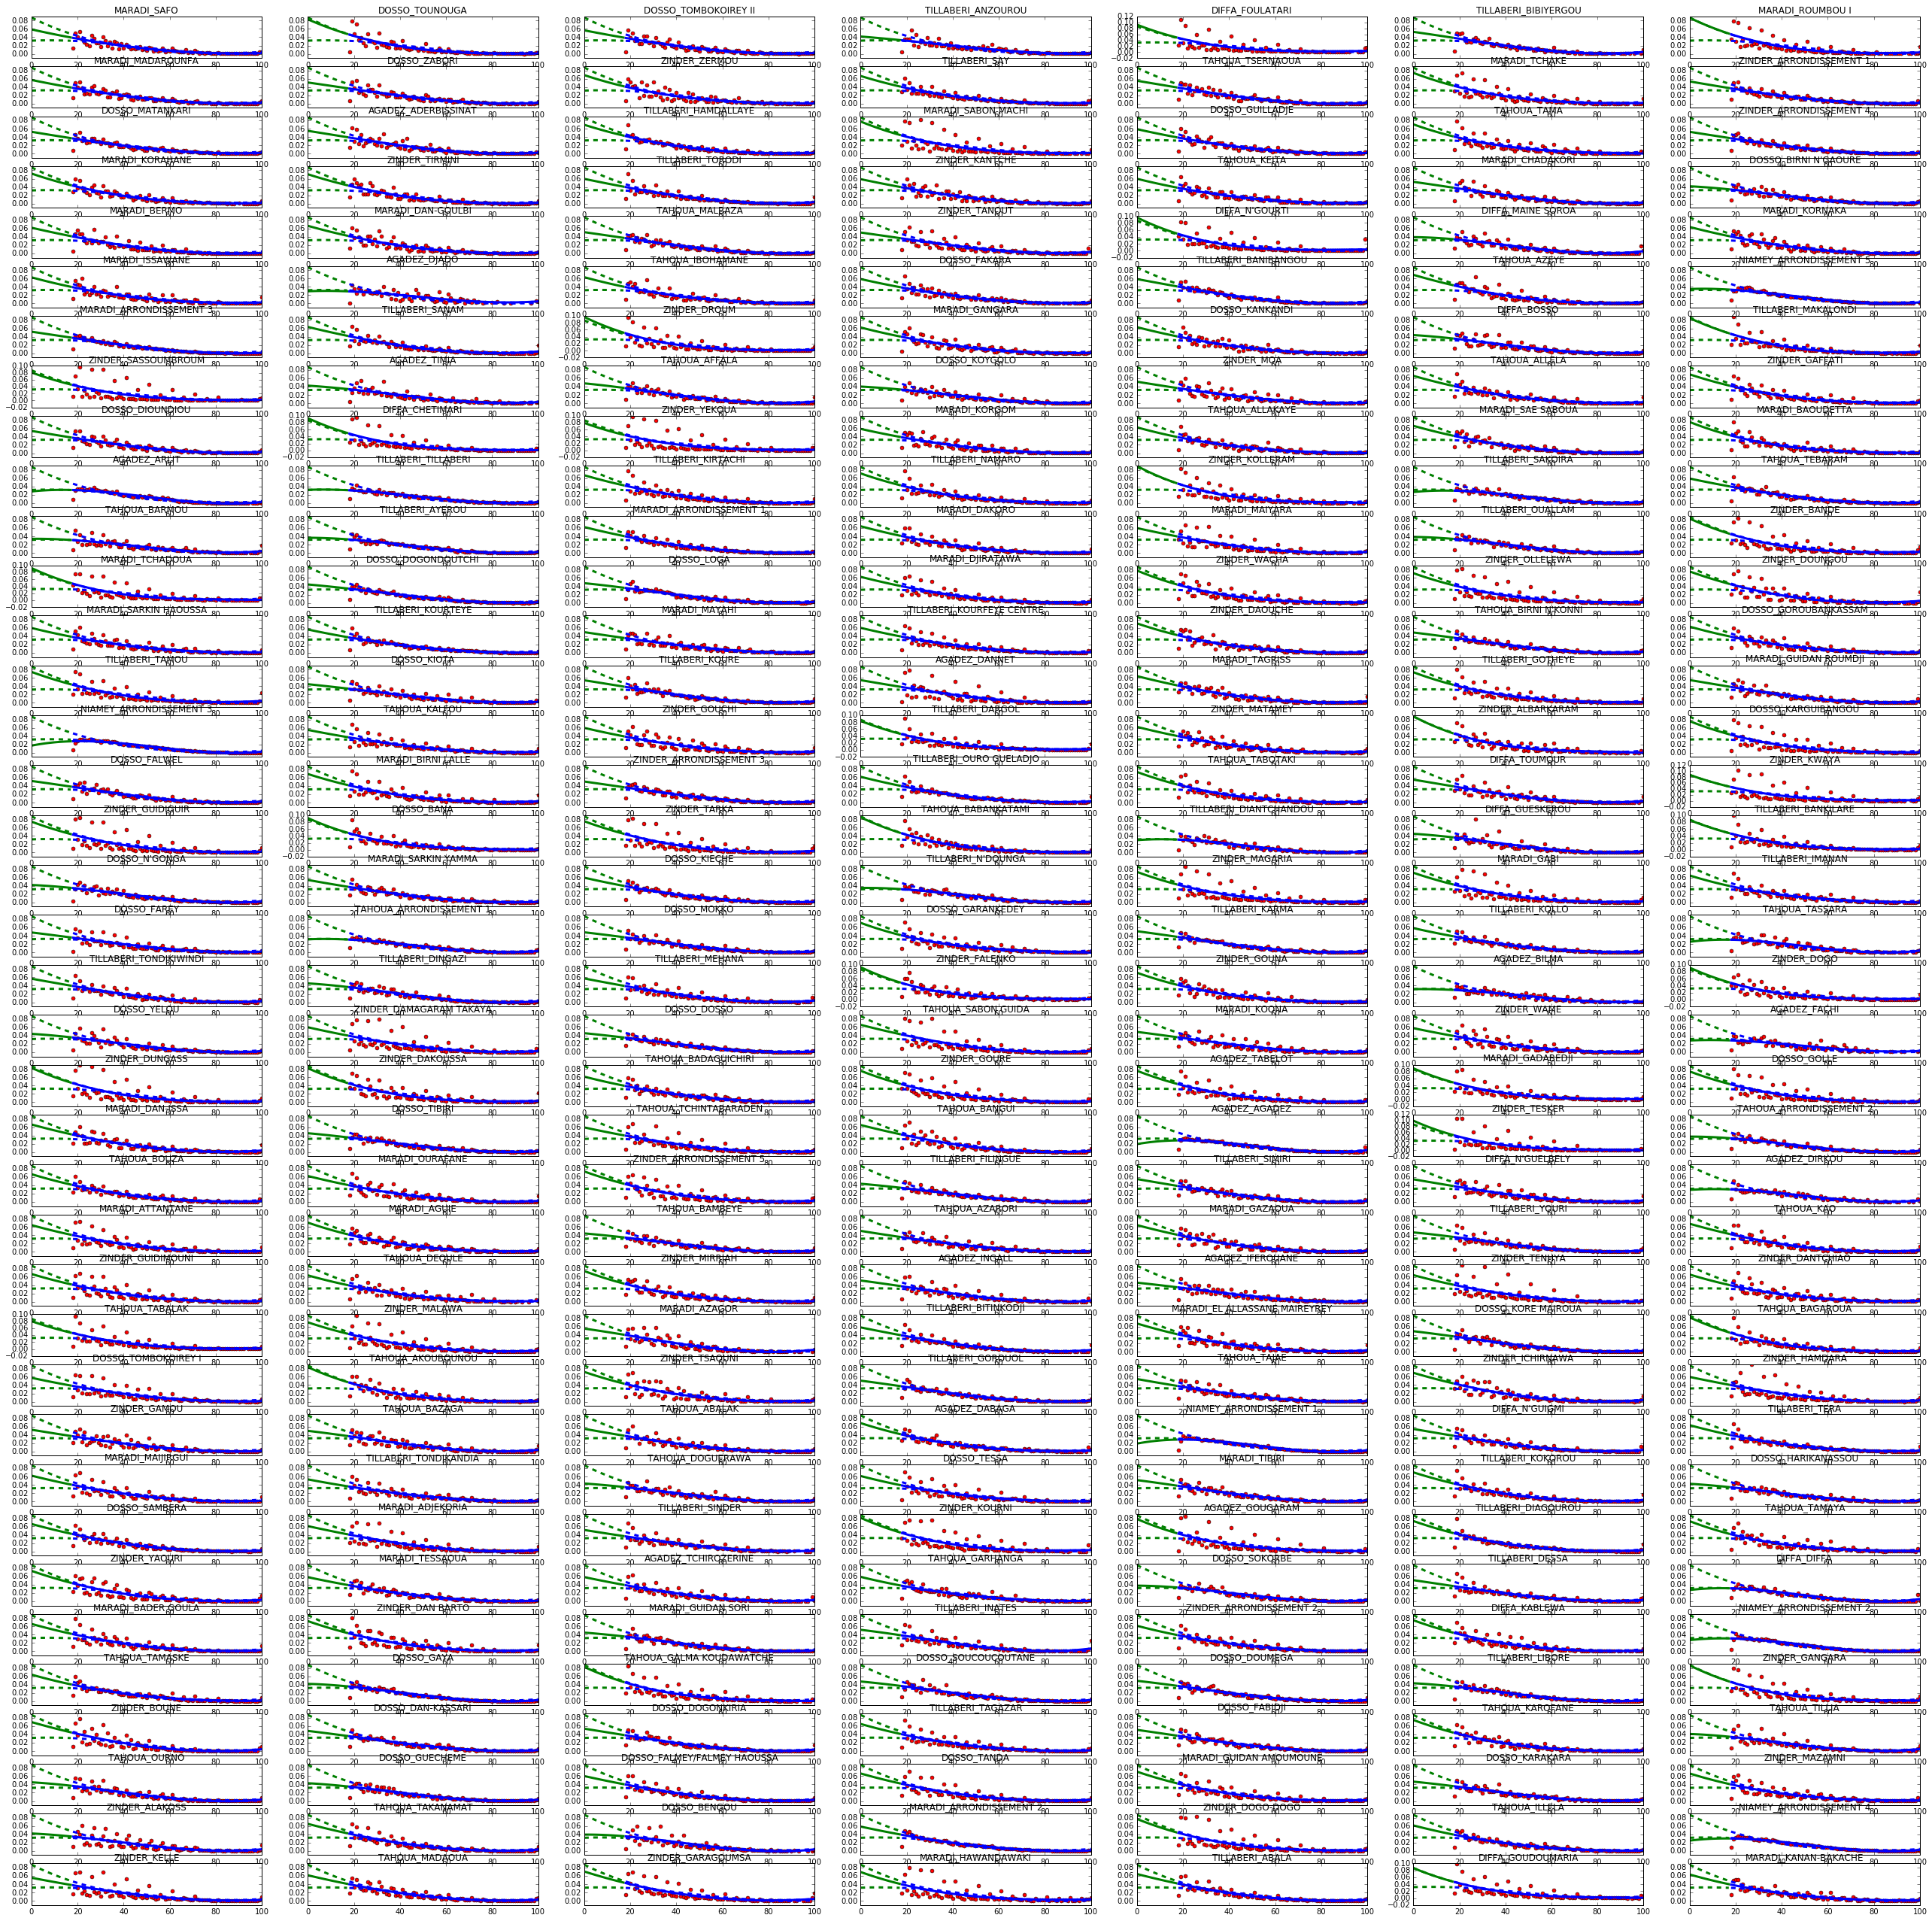

In [68]:
nrow = 38
ncol = 7

if plotting == True :
    f, axarr = plt.subplots(nrow, ncol,figsize=(45,45))
    col = row = 0
    for commune in list(extrapolated_data.keys()) :
        extr = extrapolated_data[commune]
        axarr[row , col].plot(age_dist[(age_dist.NOM_COMMUNE == extr['commune']) & (age_dist.NOM_REGION == extr['region'])].age , 
                          age_dist[(age_dist.NOM_COMMUNE == extr['commune']) & (age_dist.NOM_REGION == extr['region'])].percentage, 'ro', ms=5 )
        
        ic = ICSplined[(ICSplined.region == extr['commune']) & (ICSplined.region == extr['region'])]
        
        axarr[row , col].plot(list(range(len(extr['extrapolated']) , 101)) , extr['splinned'], 'b', lw=3)
        axarr[row , col].plot(list(range(len(extr['extrapolated']) , 101)) , list(ICSplined.IC95[0][1][0]), 'b', lw=3, ls = 'dashed')
        axarr[row , col].plot(list(range(len(extr['extrapolated']) , 101)) , list(ICSplined.IC95[0][1][1]), 'b', lw=3, ls = 'dashed')
        
        axarr[row , col].plot(list(range(0 , len(extr['extrapolated']))) , extr['extrapolated'], 'g', lw=3 )
        axarr[row , col].plot(list(range(0 , len(extr['extrapolated']))) , list(ICSplined.IC95[0][0][0]), 'g', lw=3 , ls = 'dashed')
        axarr[row , col].plot(list(range(0 , len(extr['extrapolated']))) , list(ICSplined.IC95[0][0][1]), 'g', lw=3 , ls = 'dashed')
        
        axarr[row , col].set_title(commune)
        col = col + 1
        if col > (ncol - 1) :
            col = 0
            row = row + 1 

## Population Size estimation
### Just summing extrapolated age data

In [ ]:
def get_N_voters(data) :
    return len(data)

N_Voters = voters_data.groupby(['NOM_REGION' , 'NOM_DEPART' , 'NOM_COMMUNE']).apply(get_N_voters).reset_index()
N_Voters.columns = ['region' , 'departement' , 'commune' , 'n_voters']

In [ ]:
def Impute_Extra_Kids(N_Voters , extrapolated_data = extrapolated_data):
    pop = N_Voters.n_voters
    uu = N_Voters.region[list(N_Voters.index)[0]] + '_' + N_Voters.commune[list(N_Voters.index)[0]]
    total_pop = sum(extrapolated_data[uu]['extrapolated'] + extrapolated_data[uu]['splinned']) * pop
    return total_pop[list(total_pop.index)[0]]

total_pop = N_Voters.groupby(['region' , 'departement' , 'commune']).apply(Impute_Extra_Kids).reset_index()
total_pop.columns = ['region' , 'departement' ,  'commune' , 'extrapolated_data']

### Setting in data

In [ ]:
model_data = pd.merge(model_data , total_pop , on = ['region' , 'departement' , 'commune'])

In [ ]:
y = np.asarray(model_data.population_census)

x_cat = model_data[['region' , 'urbain' , 'departement']].T.to_dict().values()


v = DictVectorizer(sparse=False)
x_cat = v.fit_transform(x_cat)

x_train = np.hstack((model_data[['population_voting_list' , 'mean_age' , 'voting']] , x_cat ))

## Linear Regression
lr = linear_model.LinearRegression()
predicted_lr = cross_val_predict(lr, x_train  , y, cv=10)

error = abs(predicted_lr - y)  / y

dat = pd.DataFrame({'y':y , 'error':error , 'region':model_data.region , 'commune':model_data.commune , 'predicted':predicted_lr})

nrow = 4
ncol = 2

if plotting == True :
    f, axarr = plt.subplots(nrow, ncol,figsize=(15,15))
    col = row = 0
    for region in list(dat['region'].unique()) :
        axarr[row , col].plot(dat.y[dat['region'] == region] , 
                          dat.predicted[dat['region'] == region], 'ro', ms=5 )
        axarr[row , col].plot([0 , max([max(dat.y[dat['region'] == region]) , max(dat.predicted[dat['region'] == region])])] , [0 , max([max(dat.y[dat['region'] == region]) , max(dat.predicted[dat['region'] == region])])] ,'k-')
        axarr[row , col].set_xlim(0,(max([max(dat.y[dat['region'] == region]) , max(dat.predicted[dat['region'] == region])]) + 1000))
        axarr[row , col].set_ylim(0,(max([max(dat.y[dat['region'] == region]) , max(dat.predicted[dat['region'] == region])]) + 1000))
        axarr[row , col].set_title(region)
        col = col + 1
        if col > (ncol - 1) :
            col = 0
            row = row + 1 

In [ ]:
n, bins, patches = plt.hist(error, 40, normed=1, facecolor='green', alpha=0.75)

In [ ]:
x_train = np.hstack((model_data[['extrapolated_data' , 'mean_age' , 'voting' ]] , x_cat ))

## Linear Regression
lr = linear_model.LinearRegression()
predicted_lr = cross_val_predict(lr, x_train  , y, cv=10)

error = abs(predicted_lr - y)  / y

dat = pd.DataFrame({'y':y , 'error':error , 'region':model_data.region , 'commune':model_data.commune , 'predicted':predicted_lr})

nrow = 4
ncol = 2

if plotting == True :
    f, axarr = plt.subplots(nrow, ncol,figsize=(15,15))
    col = row = 0
    for region in list(dat['region'].unique()) :
        axarr[row , col].plot(dat.y[dat['region'] == region] , 
                          dat.predicted[dat['region'] == region], 'ro', ms=5 )
        axarr[row , col].plot([0 , max([max(dat.y[dat['region'] == region]) , max(dat.predicted[dat['region'] == region])])] , [0 , max([max(dat.y[dat['region'] == region]) , max(dat.predicted[dat['region'] == region])])] ,'k-')
        axarr[row , col].set_xlim(0,(max([max(dat.y[dat['region'] == region]) , max(dat.predicted[dat['region'] == region])]) + 1000))
        axarr[row , col].set_ylim(0,(max([max(dat.y[dat['region'] == region]) , max(dat.predicted[dat['region'] == region])]) + 1000))
        axarr[row , col].set_title(region)
        col = col + 1
        if col > (ncol - 1) :
            col = 0
            row = row + 1 

In [ ]:
n, bins, patches = plt.hist(error, 40, normed=1, facecolor='green', alpha=0.75)

In [ ]:
results = smf.mixedlm('population_census ~ population_voting_list + mean_age + voting + urbain ', data=model_data , groups=model_data['region']).fit()

# Inspect the results
print(results.summary())

In [ ]:
def get_variables_def(results) :
    """
    Function that goes through a statsmodel summary and returns list of variables and values to include in prediction
    """ 
    variables = list(results.params.keys())
    variable_list = {}
    for var in variables :
        value = ''
        out = {'variable':var}
        var_split = var.split('[')
        if len(var_split) > 1 :
            value = var_split[1].replace(']' , '').replace('T.' , '')
            out = {'variable':var_split[0] , 'value':value , 'parametre':var}
        variable_list[var] = out
    return variable_list

In [ ]:
def pred_random_effect(re_model , test_data , random_effect):
    """
    Function that returns the response of a statsmodel random effect linear model
    """
    test_data['Intercept'] = test_data['Intercept RE'] = 1
    params = re_model.params
    variables = get_variables_def(re_model)
    out = 0
    for var in list(variables.keys()) :
        v = variables[var]
        if len(v) > 1 :
            out = out + params[v['parametre']]*(str(test_data[v['variable']]) == v['value'])
        if len(v) == 1 :
            out = out + params[v['variable']]*test_data[v['variable']]
    
    if len(test_data[random_effect].unique()) > len(results.random_effects.Intercept) :
        missing = test_data.loc[(test_data[random_effect].isin(list(results.random_effects.Intercept.index)) == False) , random_effect].unique()
        for reg in missing :
            print(missing + ' is missing')
            re_model.random_effects.Intercept[reg] = 0
    
    random_effects = list(re_model.random_effects.Intercept[test_data.loc[: , random_effect]])
    
    out =  out + random_effects
       
    return out

In [ ]:
def k_fold_validation(n_folds , data , model , random_effect):
    samp = np.random.choice(len(data), len(data) , replace = False)
    test_out = ''
    for i in range(1,(n_folds + 1)):
        #print('fold nbr : ' + str(i))
        out = samp[((i- 1)*(len(data)/n_folds)):((i)*(len(data)/n_folds))]
        train_dat = data[~data.index.isin(out)]
        test_dat = data[data.index.isin(out)]
        results = smf.mixedlm(model , data = train_dat , groups = train_dat[random_effect]).fit()
        test_dat['prediction'] = pred_random_effect(results , test_dat , random_effect)
        if len(test_out) > 0 :
            test_out = test_out.append(test_dat)
        elif len(test_out) == 0 :
            test_out = test_dat       
    return test_out

In [ ]:
def rmse(data , predicted):
    return np.sqrt(np.average(((data - predicted) * (data - predicted))))

In [ ]:
rmses = []
n_folds = 2
final_test = k_fold_validation(n_folds , model_data , 'population_census ~ population_voting_list + mean_age + voting + urbain + prop_women' , 'region')

In [ ]:
def to_run(t) :
    final_test = 'final'
    #print(final_test)
    final_test = k_fold_validation(4 , model_data , 'population_census ~ population_voting_list + mean_age + voting + urbain + prop_women' , 'region')
    return final_test

In [ ]:
def get_validation():
    test_out = k_fold_validation(n_folds , model_data , 'population_census ~ population_voting_list + mean_age + voting + urbain + prop_women' , 'region')
    rmses = rmse(test_out.population_census , test_out.prediction)
    return {'result_test':test_out , 'rmses':rmses}

In [ ]:
n, bins, patches = plt.hist(rmses , 50 , normed=1 , facecolor='green' , alpha=0.75)

In [ ]:
dat = pd.DataFrame({'y':final_test.population_census , 'region':final_test.region , 'commune':final_test.commune , 'predicted':final_test.prediction})

nrow = 4
ncol = 2

f, axarr = plt.subplots(nrow, ncol,figsize=(15,15))
col = row = 0
for region in list(dat['region'].unique()) :
    axarr[row , col].plot(dat.y[dat['region'] == region] , 
                          dat.predicted[dat['region'] == region], 'ro', ms=5 )
    axarr[row , col].plot([0 , max([max(dat.y[dat['region'] == region]) , max(dat.predicted[dat['region'] == region])])] , [0 , max([max(dat.y[dat['region'] == region]) , max(dat.predicted[dat['region'] == region])])] ,'k-')
    axarr[row , col].set_xlim(0,(max([max(dat.y[dat['region'] == region]) , max(dat.predicted[dat['region'] == region])]) + 5000))
    axarr[row , col].set_ylim(0,(max([max(dat.y[dat['region'] == region]) , max(dat.predicted[dat['region'] == region])]) + 5000))
    axarr[row , col].set_title(region)
    col = col + 1
    if col > (ncol - 1) :
        col = 0
        row = row + 1 

In [ ]:
def get_cov_95(data):
    q025 = data.prediction.quantile(0.025)
    q975 = data.prediction.quantile(0.975)
    
    population_census = data.population_census.unique()
        
    covered = (q975 > population_census) & (q025 < population_census)
    return covered[0]

def coverage(cov95):
    return sum(cov95[0]) / len(cov95)

In [ ]:
cov95 = final_test.groupby(['region' , 'commune']).apply(get_cov_95)
cov95.reset_index().groupby(['region']).apply(coverage)

# Results

## Maps

## Age structure reconstitution

## Population Prediction

# Next steps